<a href="https://colab.research.google.com/github/Tommyngo61/MovieRecommendationSystem/blob/main/MovieRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Movie recommendation system using content filtering and collabrative filtering and k-means**

Steps for project
1.  Declare dependencies
2.  Load Dataset into project
3.  Analyze data, Check for sparsity
4.  Create User-Item matrix
5.  Use CF algorithm for a single user
6.  Normalize matrix (subtracting mean rating of each user)
7.  Assign user similarity (cosign)
8.  KNN top x neighbors
9.  Fill in missing ratings for users with predicted ratings




Content filtering algorithm
1.  User rating copied for each genre
2.  Agg and avg each genre's rating
3.  Predicate each missing movie rating by averaging every genre's rating
4.  Matrix mutliple with predicated rating
5.  Using new user-movie matrix predict next movie with highest rating that has not already been seen

Collaborative filtering algorithm
1.  
2.  Load Dataset into project
3.  
4.  
5.


In [ ]:
#Data processing
import pandas as pd
import numpy as np
import scipy.stats

#visualization
import seaborn as sns

#similarity
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
# Data Citation:
# F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on
# Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19.

! curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2237k      0 --:--:-- --:--:-- --:--:-- 2237k


In [ ]:
#Unzip data set
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
#Read in the dataset
movies = pd.read_csv('data/ml-latest-small/movies.csv')
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#get dataset info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
#Number of users
print('Number of unique user: ', ratings['userId'].nunique())
#Number of movies
print('Number of unique movies: ', ratings['movieId'].nunique())
#Number of ratings
print('Number of ratings: ', ratings['rating'].nunique())
#List of unique ratings
print('Unique ratings are: ', sorted(ratings['rating'].unique()))

Number of unique user:  610
Number of unique movies:  9724
Number of ratings:  10
Unique ratings are:  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [ ]:
#Merge ratings and movie datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
#Filter movies to keep movies over 100 ratings
#Aggregate by movie title - agg movies with 100 or more ratings
agg_ratings = df.groupby('title').agg(mean_rating=('rating', 'mean'), number_of_ratings=('rating', 'count')).reset_index()

agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings'] >= 100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              138 non-null    object 
 1   mean_rating        138 non-null    float64
 2   number_of_ratings  138 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.3+ KB


In [ ]:
#Check popular Movies
agg_ratings_GT100.sort_values(by='mean_rating', ascending=False).head()

,title,mean_rating,number_of_ratings
7593,"Shawshank Redemption, The (1994)",4.429022,317
3499,"Godfather, The (1972)",4.289062,192
3011,Fight Club (1999),4.272936,218
3500,"Godfather: Part II, The (1974)",4.259690,129
2334,"Departed, The (2006)",4.252336,107


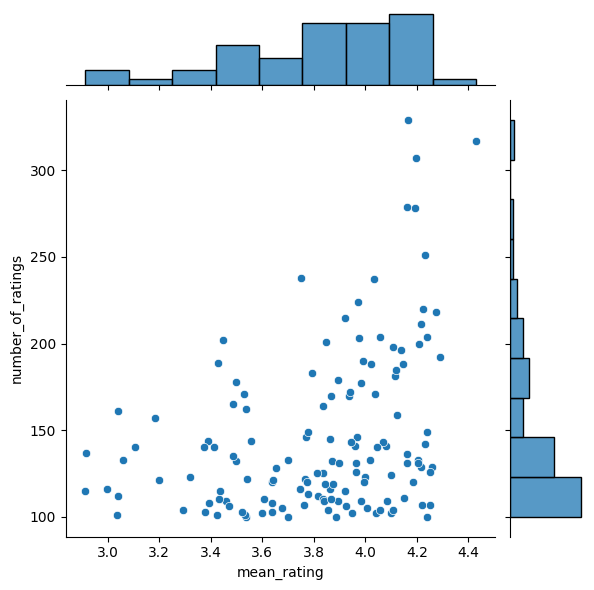

In [ ]:
#visualization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [ ]:
#Merge user to movies to keep only movies with 100 or more ratings
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20188 entries, 0 to 20187
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     20188 non-null  int64  
 1   movieId    20188 non-null  int64  
 2   rating     20188 non-null  float64
 3   timestamp  20188 non-null  int64  
 4   title      20188 non-null  object 
 5   genres     20188 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 946.4+ KB


In [ ]:
#Number of users
print('Number of unique user: ', df_GT100['userId'].nunique())
#Number of movies
print('Number of unique movies: ', df_GT100['movieId'].nunique())
#Number of ratings
print('Number of ratings: ', df_GT100['rating'].nunique())
#List of unique ratings
print('Unique ratings are: ', sorted(df_GT100['rating'].unique()))

Number of unique user:  597
Number of unique movies:  138
Number of ratings:  10
Unique ratings are:  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [ ]:
#Create user-movie matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",V for Vendetta (2006),WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,3.0,NaN,5.0,NaN,NaN,NaN,5.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
5,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Extract avg rate of each user
#Assign pos val if user rates higher than avg
#Assign neg val if user rates lower than avg
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis='rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",V for Vendetta (2006),WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.403509,NaN,NaN,0.596491,0.596491,NaN,-0.403509,...,NaN,NaN,-1.403509,NaN,0.596491,NaN,NaN,NaN,0.596491,0.596491
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.555556,NaN,NaN,NaN,1.555556,NaN,NaN,NaN,...,NaN,-1.444444,NaN,NaN,NaN,NaN,NaN,NaN,0.555556,NaN
5,NaN,-0.461538,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN,NaN


In [ ]:
#identify similar users
#User similarity matrix using pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.395182,0.180151,-0.439941,-0.053108,0.464277,1.0,-0.037987,...,0.091574,0.254514,0.106031,-0.500000,0.770709,0.303854,-0.012077,0.228651,-0.175412,0.071553
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.395182,NaN,NaN,1.000000,-0.394823,0.421927,0.704093,0.055442,NaN,0.541119,...,-0.360844,0.562500,0.196187,-0.158114,0.905206,0.057797,-0.020659,-0.296370,NaN,-0.123595
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582


In [ ]:
#Example
#picked a user ID
picked_userid = 1
#removed picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.395182,NaN,NaN,1.000000,-0.394823,0.421927,0.704093,0.055442,NaN,0.541119,...,-0.360844,0.562500,0.196187,-0.158114,0.905206,0.057797,-0.020659,-0.296370,NaN,-0.123595
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,0.000000,-0.127385,NaN,0.957427,...,-0.292770,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567


In [ ]:
#Number of similar Users
n=10

#User similarity threashold
user_similarity_threshold = 0.3

#Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

#print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
598    1.000000
9      1.000000
550    1.000000
502    1.000000
108    1.000000
401    0.942809
511    0.925820
366    0.872872
154    0.866025
595    0.866025
Name: 1, dtype: float64


In [ ]:
#narrow down item pool
#1.remove movies that have been watched by target user (user id 1 in this example)
#2.keep only movies that similar users have watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,Alien (1979),American Beauty (1999),American History X (1998),Apocalypse Now (1979),Austin Powers: International Man of Mystery (1997),Back to the Future (1985),Batman (1989),"Big Lebowski, The (1998)",Braveheart (1995),Clear and Present Danger (1994),...,Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Stargate (1994),"Terminator, The (1984)",Toy Story (1995),Twister (1996),"Usual Suspects, The (1995)",Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.403509,0.596491,0.596491,-0.403509,0.596491,0.596491,-0.403509,0.596491,-0.403509,-0.403509,...,0.596491,0.596491,0.596491,-1.403509,0.596491,-0.403509,-1.403509,0.596491,0.596491,0.596491


In [ ]:
#movies that similar users watched. Removed movies that none of the similar useres have watched
similar_users_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_users_movies

title,Aladdin (1992),Alien (1979),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Back to the Future (1985),Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)",Braveheart (1995),...,"Silence of the Lambs, The (1991)",Spider-Man (2002),Star Wars: Episode I - The Phantom Menace (1999),Terminator 2: Judgment Day (1991),Titanic (1997),Toy Story (1995),Up (2009),"Usual Suspects, The (1995)",V for Vendetta (2006),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,0.466667,0.466667,NaN,0.466667,NaN,0.466667,NaN,NaN,...,NaN,0.466667,NaN,NaN,-0.533333,NaN,NaN,NaN,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN,NaN
366,NaN,NaN,NaN,NaN,-0.166667,NaN,NaN,NaN,NaN,-0.166667,...,NaN,NaN,NaN,-0.166667,NaN,NaN,NaN,NaN,-0.666667,NaN
401,-0.382353,NaN,NaN,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.117647,0.617647,NaN,NaN,0.617647
502,NaN,-0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.153846,-0.653846,NaN,NaN,NaN,-0.153846,NaN,NaN,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.277778,0.222222,NaN,NaN,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.333333,NaN,NaN,NaN,NaN,0.666667,NaN,NaN


In [ ]:
#Drop movies that user ID 1 watched from the similar user movie list

#Remove the watched movie from the movie list
similar_users_movies.drop(picked_userid_watched.columns, axis=1, inplace=True, errors='ignore')
similar_users_movies

title,Aladdin (1992),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)","Breakfast Club, The (1985)",Catch Me If You Can (2002),"Dark Knight, The (2008)",...,Ocean's Eleven (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Shawshank Redemption, The (1994)",Shrek (2001),Spider-Man (2002),Terminator 2: Judgment Day (1991),Titanic (1997),Up (2009),V for Vendetta (2006),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,0.466667,NaN,0.466667,NaN,0.466667,NaN,-0.533333,0.466667,NaN,...,NaN,NaN,NaN,NaN,0.466667,NaN,-0.533333,NaN,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN
366,NaN,NaN,-0.166667,NaN,NaN,NaN,NaN,NaN,NaN,-0.166667,...,NaN,-0.166667,NaN,NaN,NaN,-0.166667,NaN,NaN,-0.666667,NaN
401,-0.382353,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,...,NaN,0.117647,NaN,0.117647,NaN,NaN,NaN,0.617647,NaN,0.617647
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.346154,NaN,-1.153846,NaN,NaN,-0.153846,NaN,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,...,NaN,NaN,0.222222,NaN,NaN,NaN,NaN,0.222222,NaN,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Loops through items and users to get the item score, rank the score from high to low and pick the top 10 movies to recommend to user ID 1

#Dictionary to store item scores
item_score = {}

#Loop through items
for i in similar_users_movies.columns:
  #Get the ratings for movie i
  movie_rating = similar_users_movies[i]
  #Create a variable to store the score
  total = 0
  #Create a variable to store the number of scores
  count = 0
  #loop through similar users
  for u in similar_users.index:
    #if the movie has rating
    if pd.isna(movie_rating[u]) == False:
      #score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      #Add the score to the total score for the movie so far
      total += score
      #Add 1 to the count
      count +=1
  #Get the average score for the item
  item_score[i] = total / count

  #Convert dict to pandas df
  item_score_df = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

  #Sort the movies by score
  ranked_item_score = item_score_df.sort_values(by='movie_score', ascending=False)

  #select top m movies
  m=10
  #Create a list of the top m movies
  ranked_item_score.head(m)

